In [68]:
import matplotlib.pyplot as plt
import numpy as np
from fit_tools import *
from deproject_vis import deproject_vis
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
import scipy

In [108]:
## define data and directories

incl, PA = 36.5, 147.5

# location of visibilities
visdir = '/Users/calebpainter/Downloads/Research/THESIS/data/vis_stuff/iter_vis/'

# location of posteriors subdirectory
postdir = '/Users/calebpainter/Downloads/Research/THESIS/codes/outputs/'
plotdir = '/Users/calebpainter/Downloads/Research/THESIS/plots/vis/'

## define data

targ = 'MWC480'
cals = ['0','1','1f','2','3']

disks = ['_Q.contp0', '_Q.contp1', 
        '_A.contp0', '_A.contp1', '_A.contp2', '_A.contp3',
        '_K.contp0', '_K.contp1', '_K.contp2', '_K.contp3',
        '_U.contp0', '_U.contp1', '_U.contp2', '_U.contp3',
        '_X.contp0-peeled', '_X.contp1-peeled', '_X.contp2-peeled', '_X.contp3-peeled',
        '_C.contp0', '_C.contp1', '_C.contp2', '_C.contp3',
        '_C.contp1f', '_C.contp1f', '_C.contp1f', '_C.contp1f']


In [106]:
## define classes
class Visibility:
            def __init__(self, vis, u, v, wgt):
                self.vis = vis
                self.u = u
                self.v = v
                self.wgt = wgt

## load visibilities
def load_data(band, cal):
    _ = np.load(visdir+targ+'_'+band+'.'+f'contp{cals[cal]}.vis.npz')
    return  (_['Vis'], _['u'], _['v'], _['Wgt'])


## load posteriors
def load_posteriors(band, cal):
    _ = np.load(postdir+targ+'_'+band+'.'+f'contp{cals[cal]}.point.post.npz')
    return  _

def plot_model(band,cal,model_type, ax):
    
    vis_data = load_data(band, cal)
    posteriors = load_posteriors(band,cal)
    samples = posteriors['chain']
    samples[:,0] *= 1e6

    # fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5.5, 7.5), 
    #                 constrained_layout=True,
    #                 gridspec_kw={'height_ratios':[2, 1], 'hspace':0.10})

    duv = 2
    uvbins = np.arange(1, 125, duv)
    clevs = [15.85, 50., 84.15]
    CI = np.percentile(samples, clevs, axis=0)

    # actual data deprojected
    vp = deproject_vis(Visibility(vis_data[0], vis_data[1], vis_data[2], vis_data[3]), uvbins, incl=0, PA=0,
                            offx=CI[1,1], offy=CI[1,2])
    

    # plot posteriors
    ndraws = 30
    # drawing random values from the samples chain to plot many paths
    rix = np.random.randint(0, samples.shape[0], ndraws)
    for j in tqdm(range(ndraws)):
        if model_type == 'point':
            mdraw = ptsrc_model(samples[rix[j],:], vis_data[1], vis_data[2])
        if model_type == 'gaussian': 
            mdraw = gaussian_model(samples[rix[j],:], vis_data[1], vis_data[2])

        mvp = deproject_vis(Visibility(mdraw, vis_data[1], vis_data[2], vis_data[3]), uvbins, incl=0, PA=0,
                                offx=CI[1,1], offy=CI[1,2])
        ax[0].plot(1e-3*mvp.rho_uv, mvp.vis_prof.real, '-C1', alpha=0.03)
        ax[1].plot(1e-3*mvp.rho_uv, mvp.vis_prof.imag, '-C1', alpha=0.03)

    ax[0].axhline(y=0, linestyle=':', color='darkslategray')
    ax[0].errorbar(1e-3 * vp.rho_uv, 1e6 * vp.vis_prof.real, 
                yerr=1e6 * vp.err_std.real, fmt='o', color='k', zorder=0)
    ax[0].set_xlim([0, 1.1*uvbins.max()])
    ax[0].set_ylim([-0.1*1e6*vp.vis_prof.real.max(), 
                    1.25*1e6*vp.vis_prof.real.max()])
    ax[0].set_ylabel('real visibilities (uJy)')
    ax[0].set_xlabel('deprojected baseline length (k_lambda)')

    ax[1].axhline(y=0, linestyle=':', color='darkslategray')
    ax[1].errorbar(1e-3 * vp.rho_uv, 1e6 * vp.vis_prof.imag, 
                yerr=1e6 * vp.err_std.imag, fmt='o', color='k', zorder=0)
    ax[1].set_xlim([0, 1.1*uvbins.max()])
    ax[1].set_ylim([-1.25*1e6*vp.vis_prof.imag.max(),
                    1.25*1e6*vp.vis_prof.imag.max()])
    ax[1].set_ylabel('imag visibilities (uJy)')
    ax[1].set_xlabel('deprojected baseline length (k_lambda)')

    ax[0].set_ylim(-500,4000)
    ax[1].set_ylim(-3000,3000)

    ax[0].set_title(f'Cal: {cals[cal]}')

In [114]:
posteriors = load_posteriors('A',1)
chain = posteriors['chain']

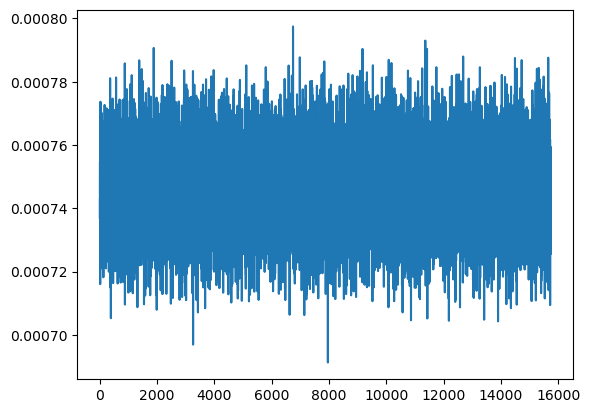

In [115]:
plt.plot([x[0] for x in chain])

100%|██████████| 30/30 [00:00<00:00, 43.80it/s]


Text(0.5, 0.98, 'Band A')

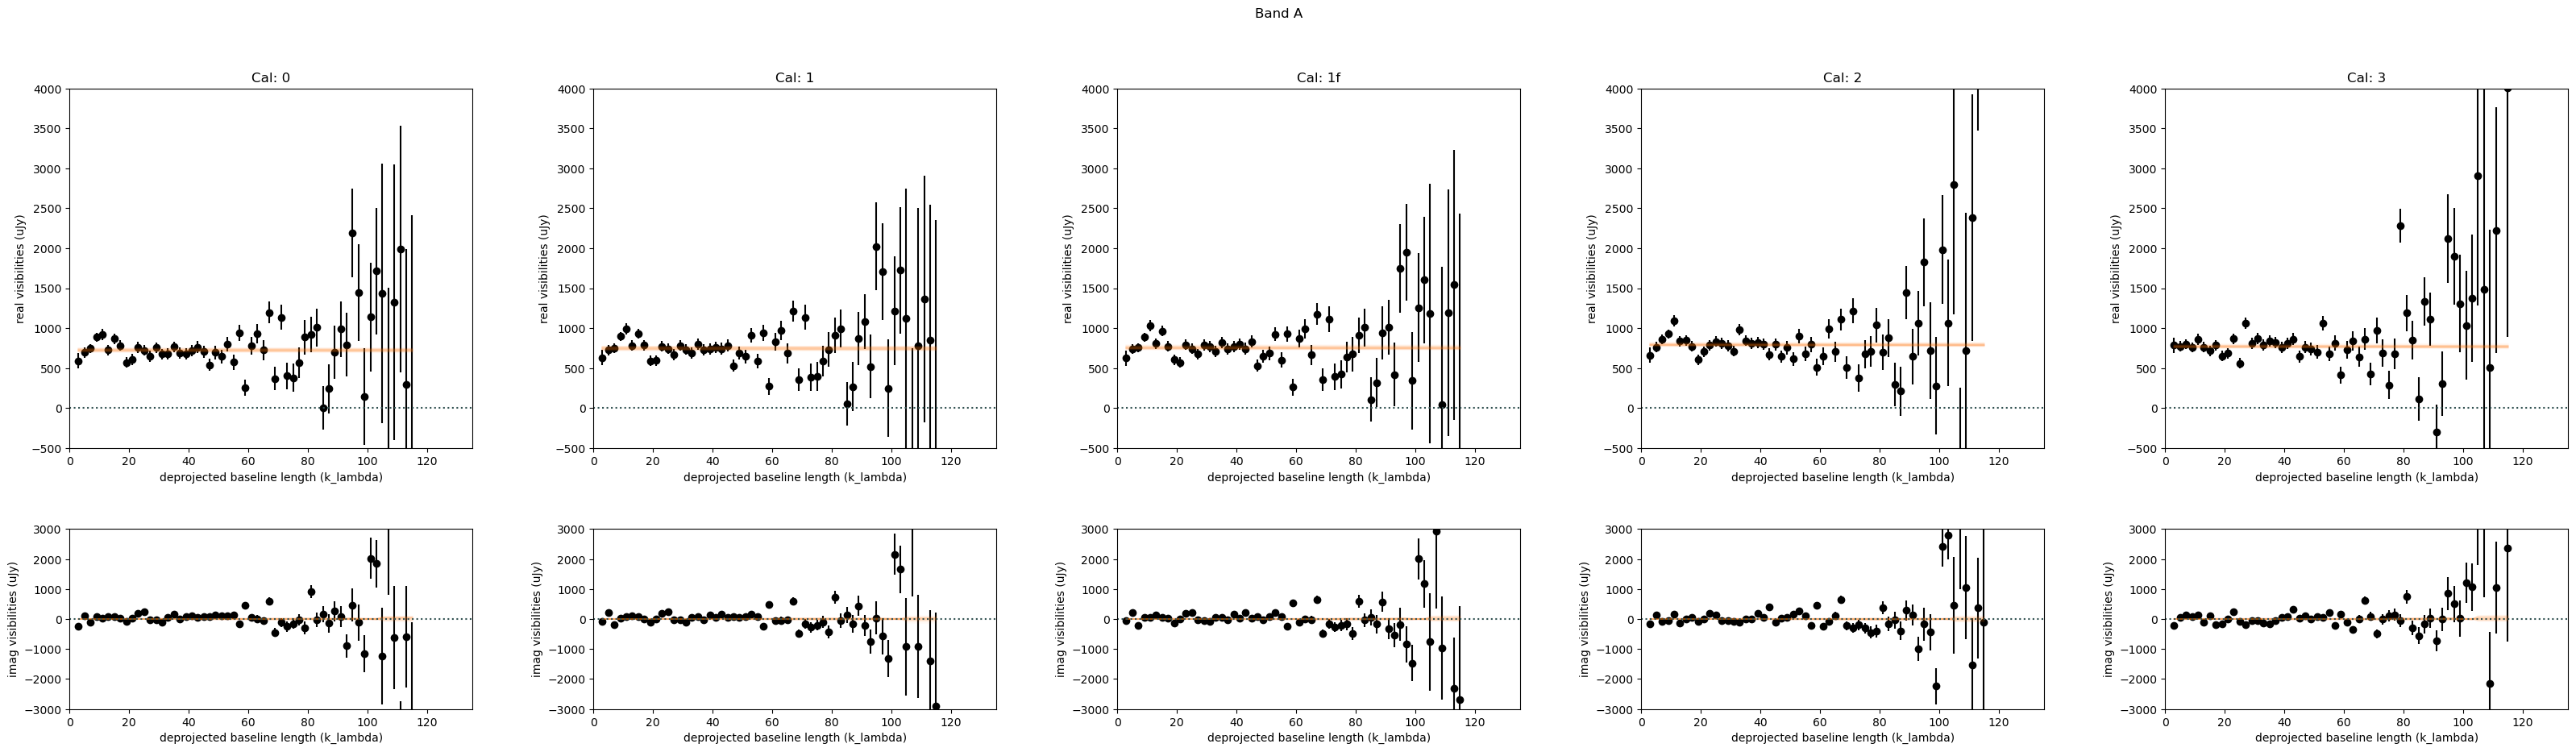

In [109]:
band = 'A'

fig = plt.figure(figsize=(40, 10))
gs = GridSpec(2, 5, figure=fig, height_ratios=[2, 1], hspace=0.3, wspace=0.3)

# Loop through 5 panels (columns in the GridSpec) and pass appropriate axes to plot_model
for cal in range(5):
    ax_real = fig.add_subplot(gs[0, cal])  # Top row for real part
    ax_imag = fig.add_subplot(gs[1, cal])  # Bottom row for imaginary part
    plot_model(band,cal,'point', (ax_real, ax_imag))  # You can replace 'point' with 'gaussian' if needed

fig.suptitle(f'Band {band}')

In [55]:
np.sort(os.listdir('/Users/calebpainter/Downloads/Research/THESIS/data/vis_stuff/iter_vis/'))

array(['MWC480_A.contp0.vis.npz', 'MWC480_A.contp1.vis.npz',
       'MWC480_A.contp1f.vis.npz', 'MWC480_A.contp2.vis.npz',
       'MWC480_A.contp3.vis.npz', 'MWC480_K.contp0.vis.npz',
       'MWC480_K.contp1.vis.npz', 'MWC480_K.contp1f.vis.npz',
       'MWC480_K.contp2.vis.npz', 'MWC480_K.contp3.vis.npz',
       'MWC480_Q.contp0.vis.npz', 'MWC480_Q.contp1.vis.npz',
       'MWC480_Q.contp1f.vis.npz', 'MWC480_Q.contp2.vis.npz',
       'MWC480_Q.contp3.vis.npz', 'MWC480_U.contp0.vis.npz',
       'MWC480_U.contp1.vis.npz', 'MWC480_U.contp1f.vis.npz',
       'MWC480_U.contp2.vis.npz', 'MWC480_U.contp3.vis.npz',
       'MWC480_X.contp0-peeled.vis.npz', 'MWC480_X.contp1-peeled.vis.npz',
       'MWC480_X.contp1f-peeled.vis.npz',
       'MWC480_X.contp2-peeled.vis.npz', 'MWC480_X.contp3-peeled.vis.npz'],
      dtype='<U31')

18.857539475828993


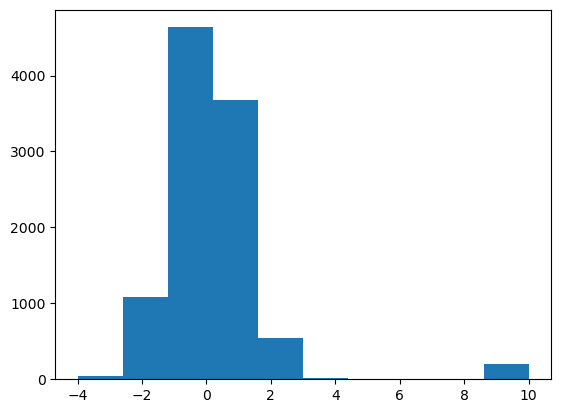

In [104]:
noise = list(np.random.normal(size=10000))
signal = [10]*200
data = noise+signal
data = data * 1
plt.hist(data)
print(scipy.stats.kurtosis(data))